<a href="https://colab.research.google.com/github/ubiratantavares/aprendizado_profundo_para_series_temporais/blob/main/tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Classe File

In [51]:
from pandas import read_csv

class File:
    
    def __init__(self, name):
        self.name = name
        
    # load dataset
    def load(self):
        series = read_csv(self.name, header=0, index_col=0)
        return series    
    
    # summarize dataset
    def summarize(self):
        series = self.load()
        print(series.shape)

#### Classe Dataset

In [52]:
class Dataset:
    
    def __init__(self, series):
        self.data = series.values

    # split a univariate dataset into train/test sets
    def train_test_split(self, n_test):
        return self.data[:-n_test], self.data[-n_test:]

#### Classe Plot

In [53]:
from matplotlib import pyplot as plt

class Plot:
    
    def __init__(self, data):
        self.data = data
    
    # create plot line
    def line(self):
        plt.plot(self.data)
        plt.show() 
        
    # create box and whisker plot
    def boxplot(self):
        plt.boxplot(self.data)
        plt.show()

#### Classe Measure

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import sqrt

class Measure:
    
    def __init__(self):
        pass
    
    # measure generic
    def calculated(self, y_true, y_pred):
        pass    
    
    def print_error(self, i, error):
        print('{}: {:.3f}'.format(str(i+1), error))
    
# Mean Absolute Error (MAE)    
class MAE(Measure):    

    def calculated(self, y_true, y_pred):
        return mean_absolute_error(y_true, y_pred)
    
# Mean Squared Error (MSE)
class MSE(Measure):
    
    def calculated(self, y_true, y_pred):
        return mean_squared_error(y_true, y_pred)
    
# Root Mean Squared Error (RMSE) 
class RMSE(Measure):
   
    def calculated(self, y_true, y_pred):
        return mean_squared_error(y_true, y_pred, squared=False)

class RMSE2(Measure):

    # Root Mean Squared Error (RMSE)
    def calculated(self, y_true, y_pred):
        return sqrt(mean_squared_error(y_true, y_pred))

#### Classe Model

In [55]:
from pandas import DataFrame, concat
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D, MaxPooling1D

class Model:
    
    def __init__(self):
        pass
        
    def fit(self, train, config):
        pass   
    

    # transform list into supervised learning format
    def series_to_supervised(self, train, n_in=1, n_out=1):
        df = DataFrame(train)
        cols = list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
        # put it all together
        agg = concat(cols, axis=1)
        # drop rows with NaN values
        agg.dropna(inplace=True)
        return agg.values    
    
    # difference dataset
    def difference(self, train, interval):        
        return [(train[i] - train[i - interval]) 
                for i in range(interval, len(train))]
    
class Persistence(Model):
    
    # fit a model persistence
    def fit(self, train, config):
        return None
    

class MLP(Model): 

    # fit a model mlp
    def fit(self, train, config):
        # unpack config
        n_input, n_nodes, n_epochs, n_batch, activation, loss, optimizer = config
        # prepare data
        data = self.series_to_supervised(train, n_in=n_input)
        train_x, train_y = data[:, :-1], data[:, -1]
        # define model        
        model = Sequential()
        
        model.add(Dense(n_nodes, activation=activation, input_dim=n_input))
        
        model.add(Dense(1))
        
        model.compile(loss=loss, optimizer=optimizer)
        
        # fit
        model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
        return model   
   
    
    
class CNN(Model):
    
    # fit a model
    def fit(self, train, config):
        # unpack config
        n_input, n_filters, n_kernel, n_epochs, n_batch, activation, loss, optimizer = config
    	
        # prepare data
        data = self.series_to_supervised(train, n_in=n_input)
        train_x, train_y = data[:, :-1], data[:, -1]
        
        train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
        
        # define model
        model = Sequential()
        
        model.add(Conv1D(filters=n_filters, 
                         kernel_size=n_kernel, 
                         activation=activation, 
                         input_shape=(n_input, 1)))
        
        model.add(Conv1D(filters=n_filters, 
                         kernel_size=n_kernel, 
                         activation=activation))
        
        model.add(MaxPooling1D(pool_size=2))
        
        model.add(Flatten())
        
        model.add(Dense(1))
        
        model.compile(loss=loss, optimizer=optimizer)
        
    	# fit
        model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
        return model
    
    
class LSTMModel(Model):
    
    def fit(self, train, config):
        # unpack config
        n_input, n_nodes, n_epochs, n_batch, activation, loss, optimizer = config

    	# prepare data      
        data = self.series_to_supervised(train, n_in=n_input)

        train_x, train_y = data[:, :-1], data[:, -1]
        
        train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
        
        # define model
        model = Sequential()
        model.add(LSTM(n_nodes, activation=activation, input_shape=(n_input, 1)))
        model.add(Dense(n_nodes, activation=activation))
        model.add(Dense(1))
        model.compile(loss=loss, optimizer=optimizer)
    	
        # fit
        model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
        return model        
    
   
    
class CNNLSTM(Model):   
    
    def fit(self, train, config):
        # unpack config
        n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, activation, loss, optimizer = config
        n_input = n_seq * n_steps
        
        # prepare data
        data = self.series_to_supervised(train, n_in=n_input)
        train_x, train_y = data[:, :-1], data[:, -1]
        train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
        
        # define model
        model = Sequential()
        
        model.add(TimeDistributed(Conv1D(filters=n_filters, 
                                         kernel_size=n_kernel, 
                                         activation=activation, 
                                         input_shape=(None,n_steps,1))))
        
        model.add(TimeDistributed(Conv1D(filters=n_filters, 
                                         kernel_size=n_kernel, 
                                         activation=activation)))
        
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        
        model.add(TimeDistributed(Flatten()))
        
        model.add(LSTM(n_nodes, activation=activation))
        
        model.add(Dense(n_nodes, activation=activation))
        
        model.add(Dense(1))
        
        model.compile(loss=loss, optimizer=optimizer)
        
        # fit
        model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
        return model
        
class ConvLSTM(Model):
    
    def fit(self, train, config):
        # unpack config
        n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, activation, loss, optimizer = config
        n_input = n_seq * n_steps
        # prepare data
        data = self.series_to_supervised(train, n_in=n_input)
        train_x, train_y = data[:, :-1], data[:, -1]
        train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
        # define model
        model = Sequential()
        
        model.add(ConvLSTM2D(filters=n_filters, 
                             kernel_size=(1,n_kernel), 
                             activation=activation, 
                             input_shape=(n_seq, 1, n_steps, 1)))
        
        model.add(Flatten())
        
        model.add(Dense(n_nodes, activation=activation))

        model.add(Dense(1))
        
        model.compile(loss=loss, optimizer=optimizer)
        
        # fit
        model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
        return model

#### Classe Predict

In [56]:
from numpy import median, array

class Predict:
    
    def __init__(self):
        pass
    
    def forecast(self, modelfit, history, config):
        pass
    
    
class PredictPersistente(Predict):
    
    # forecast with a pre-fit model - persistence
    def forecast(self, modelfit, history, config):
        values = list()
        for offset in config:
            values.append(history[-offset])
        return median(values)
    
    
class PredictMLP(Predict):
    # forecast with a pre-fit model - MLP
    def forecast(self, modelfit, history, config):        
        # unpack config
        n_input = config[0]

        # prepare data
        x_input = array(history[-n_input:]).reshape(1, n_input)
        
        # forecast
        y_pred = modelfit.predict(x_input, verbose=0)
        return y_pred[0]
    
    
class PredictCNN(Predict):
    
    def forecast(self, modelfit, history, config):
        # n_input, n_filters, n_kernel, n_epochs, n_batch, activation, loss, optimizer
        n_input = config[0]
        
        # prepare data
        x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	
        # forecast
        y_pred = modelfit.predict(x_input, verbose=0)
        return y_pred[0]
    
    
class PredictLSTM(Predict):
    
    def forecast(self, modelfit, history, config):
        # n_input, n_nodes, n_epochs, n_batch, activation, loss, optimizer = config
        n_input = config[0]

        # prepare data
        x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	
        # forecast
        y_pred = modelfit.predict(x_input, verbose=0)
        return y_pred[0]
    
    
class PredictCNNLSTM(Predict):
    
    def forecast(self, modelfit, history, config):
        # unpack config
        n_seq, n_steps, _, _, _, _, _, _, _, _ = config
        n_input = n_seq * n_steps
        # prepare data
        x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
        # forecast
        yhat = modelfit.predict(x_input, verbose=0)
        return yhat[0]
    
    
class PredictConvLSTM(Predict):
    
    def forecast(self, modelfit, history, config):
        # unpack config
        n_seq, n_steps, _, _, _, _, _, _, _, _ = config
        n_input = n_seq * n_steps
        # prepare data
        x_input = array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
        # forecast
        yhat = modelfit.predict(x_input, verbose=0)
        return yhat[0]

#### Classe Evaluation

In [57]:
from numpy import mean, std
from time import time

class Evaluation:
    
    def __init__(self, dataset, model, predict, measure):
        self.dataset = dataset
        self.model = model
        self.predict = predict
        self.measure = measure
        
        
    def create_predictions(self, modelfit, history, test, config):
        predictions = list()
        for i in range(len(test)):
            # fit model and make forecast for history
            y_pred = self.predict.forecast(modelfit, history, config)
            # store forecast in list of predictions
            predictions.append(y_pred)
            # add actual observation to history for the next loop
            history.append(test[i])
        return predictions
    
    
    # walk-forward validation for univariate data
    def walk_forward_validation(self, n_test, config, i):
        # split dataset
        train, test = self.dataset.train_test_split(n_test)
        
        # seed history with training dataset
        history = [x for x in train]
        
        # fit model
        modelfit = self.model.fit(train, config)

        # step over each time-step in the test set
        predictions = self.create_predictions(modelfit, history, test, config)
        
        # estimate prediction error        
        error = self.measure.calculated(test, predictions)
        # self.measure.print_error(i, error)
        return error


    # repeat evaluation of a config
    def repeat_evaluate(self, parameters):
        n_test, config, n_repeats = parameters
        
        # fit and evaluate the model n times
        scores = [self.walk_forward_validation(n_test, config, i) for i in range(n_repeats)]
        return scores


    # summarize model performance
    def summarize(self, parameters):    
        start = time()        
        scores = self.repeat_evaluate(parameters)
        scores_m = mean(scores)
        scores_std = std(scores)        
        end = time()        
        delta = end - start
        print('Time: {:.3f}s >> Measure: {:.3f} (+/- {:.3f})'.format(delta, scores_m, scores_std))
        return scores

# MAIN

In [58]:
# Load and plot dataset
f = File('/content/drive/MyDrive/dissertacao/colab/monthly-car-sales.csv')
f.summarize()

(108, 1)


In [59]:
series = f.load()
print(series)

         Sales
Month         
1960-01   6550
1960-02   8728
1960-03  12026
1960-04  14395
1960-05  14587
...        ...
1968-08  16722
1968-09  14385
1968-10  21342
1968-11  17180
1968-12  14577

[108 rows x 1 columns]


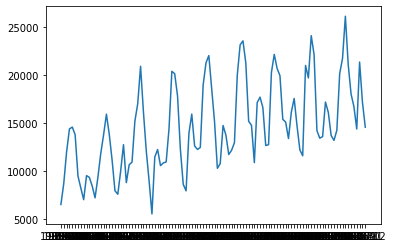

In [60]:
# create plot
p = Plot(series)
p.line()

In [61]:
# summarize dataset
data = Dataset(series)
train, test = data.train_test_split(12)
print(train.shape, test.shape)

(96, 1) (12, 1)


Time: 0.027s >> Measure: 1841.156 (+/- 0.000)


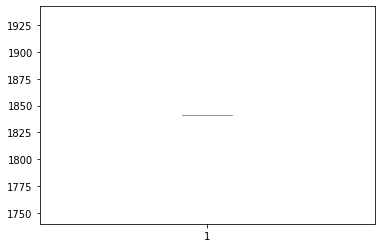

In [62]:
# Evaluate persistence model
config = [12, 24, 36]
parameters = (12, config, 30) # n_test, config, n_repeats

model = Persistence()
predicted = PredictPersistente()
measure = RMSE()

evaluation = Evaluation(data, model, predicted, measure)
scores = evaluation.summarize(parameters)
p = Plot(scores)
p.boxplot()

Time: 38.935s >> Measure: 1544.973 (+/- 160.140)


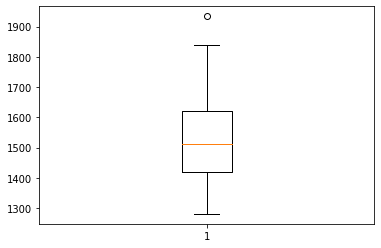

In [63]:
# Evaluate MLP model

'''
n_input: 24 (e.g. 24 months)
n_nodes: 500
n_epochs: 100
n_batch: 100
activation = 'relu'
loss = 'mse'
optimizer = 'adam'
'''
config = [24, 500, 100, 100, 'relu', 'mse', 'adam'] 

parameters = (12, config, 30) # n_test, config, n_repeats

model = MLP()
predicted = PredictMLP()

evaluation = Evaluation(data, model, predicted, measure)

scores = evaluation.summarize(parameters)
p = Plot(scores)
p.boxplot()

Time: 276.027s >> Measure: 1552.314 (+/- 72.649)


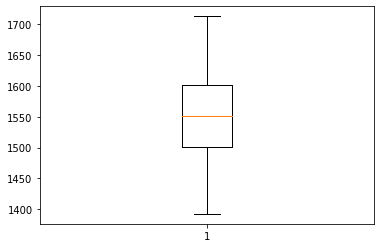

In [64]:
# Evaluate CNN model

'''
n_input: 36 (e.g. 3 years or 3 * 12)
n_filters: 256
n_kernel: 3
n_epochs: 100
n_batch: 100 (e.g. batch gradient descent)
activation = 'relu'
loss = 'mse'
optimizer = 'adam'
'''
config = [36, 256, 3, 100, 100, 'relu', 'mse', 'adam']
parameters = (12, config, 30) # n_test, config, n_repeats

model = CNN()
predicted = PredictCNN()

evaluation = Evaluation(data, model, predicted, measure)
scores = evaluation.summarize(parameters)
p = Plot(scores)
p.boxplot()

(12, [36, 50, 100, 100, 'relu', 'mse', 'adam'], 30)
Time: 126.553s >> Measure: 7613.694 (+/- 4936.382)


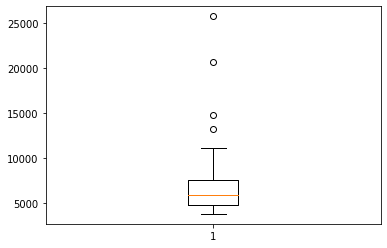

In [65]:
# Evaluate LSTM model

'''
n_input: 36 (i.e. 3 years or 3 * 12)
n_nodes: 50
n_epochs: 100
n_batch: 100 (i.e. batch gradient descent)
activation = 'relu'
loss = 'mse'
optimizer = 'adam'
'''
config = [36, 50, 100, 100, 'relu', 'mse', 'adam']

# n_test, config, n_repeats
parameters = (12, config, 30)
print(parameters)

model = LSTMModel()
predicted = PredictLSTM()

evaluation = Evaluation(data, model, predicted, measure)
scores = evaluation.summarize(parameters)
p = Plot(scores)
p.boxplot()

(12, [3, 12, 64, 3, 100, 200, 100, 'relu', 'mse', 'adam'], 30)
Time: 195.867s >> Measure: 1654.148 (+/- 150.354)


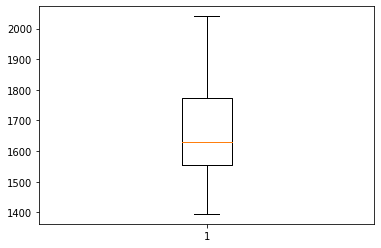

In [66]:
# Evaluate CNN LSTM model

'''
n_seq: 3 (i.e. 3 years)
n_steps: 12 (i.e. 1 year of months)
n_filters: 64
n_kernel: 3
n_nodes: 100
n_epochs: 200
n_batch: 100 (i.e. batch gradient descent)
activation = 'relu'
loss = 'mse'
optimizer = 'adam'
'''
config = [3, 12, 64, 3, 100, 200, 100, 'relu', 'mse', 'adam']

# n_test, config, n_repeats
parameters = (12, config, 30)
print(parameters)

model = CNNLSTM()
predicted = PredictCNNLSTM()

evaluation = Evaluation(data, model, predicted, measure)
scores = evaluation.summarize(parameters)
p = Plot(scores)
p.boxplot()

(12, [3, 12, 256, 3, 200, 200, 100, 'relu', 'mse', 'adam'], 30)
Time: 2864.272s >> Measure: 1631.748 (+/- 277.845)


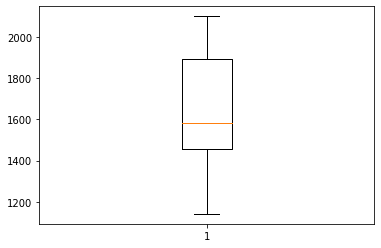

In [67]:
# Evaluate ConvLSTM model

'''
n_seq: 3 (i.e. 3 years)
n_steps: 12 (i.e. 1 year of months)
n_filters: 256
n_kernel: 3
n_nodes: 200
n_epochs: 200
n_batch: 100 (i.e. batch gradient descent)
activation = 'relu'
loss = 'mse'
optimizer = 'adam'
'''
config = [3, 12, 256, 3, 200, 200, 100, 'relu', 'mse', 'adam']

# n_test, config, n_repeats
parameters = (12, config, 30)

model = ConvLSTM()
predicted = PredictConvLSTM()

evaluation = Evaluation(data, model, predicted, measure)
scores = evaluation.summarize(parameters)
p = Plot(scores)
p.boxplot()